In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans

# 1. EDA

## 1) data Pre-processing

In [2]:
df = pd.read_excel("../dataset.xlsx",sheet_name="Sheet2",header=1)
df = df.drop(columns=['Unnamed: 0','geometry','extra','startDate','endDate','createdAt'])
df = df.dropna(axis=0)

### 주소, 지형 정보(x,y,area)와 작업 정보(Task, Team)만 추출

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111737 entries, 0 to 113039
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x       111737 non-null  float64
 1   y       111737 non-null  float64
 2   area    111737 non-null  float64
 3   TaskId  111737 non-null  int64  
 4   TeamId  111737 non-null  int64  
dtypes: float64(3), int64(2)
memory usage: 5.1 MB


## 2) Data Visualization

### 1. Area Visualization with Task ID

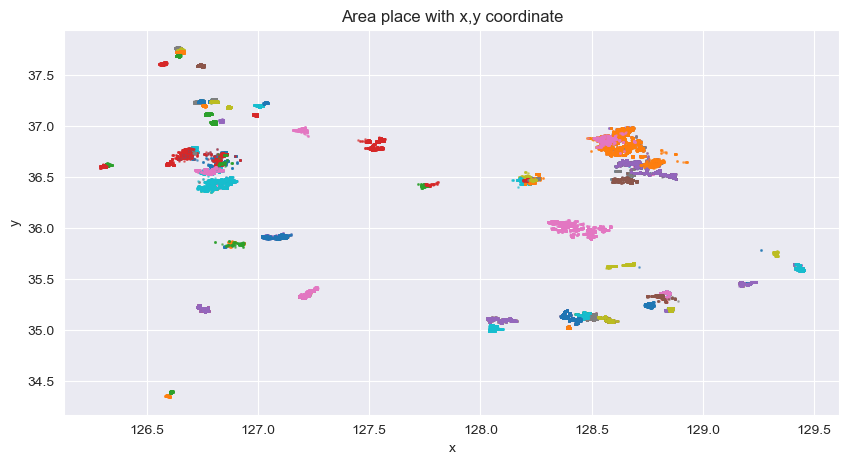

In [4]:
plt.figure(1, figsize=(10, 5))
for task_id in df['TaskId'].unique():
    plt.scatter(x = 'x' , y = 'y' , data = df[df['TaskId']==task_id],
                s = 1 , alpha = 0.5)
    plt.xlabel('x'), plt.ylabel('y')
plt.title('Area place with x,y coordinate')
plt.show()

### 2. Area Visualization with Team ID

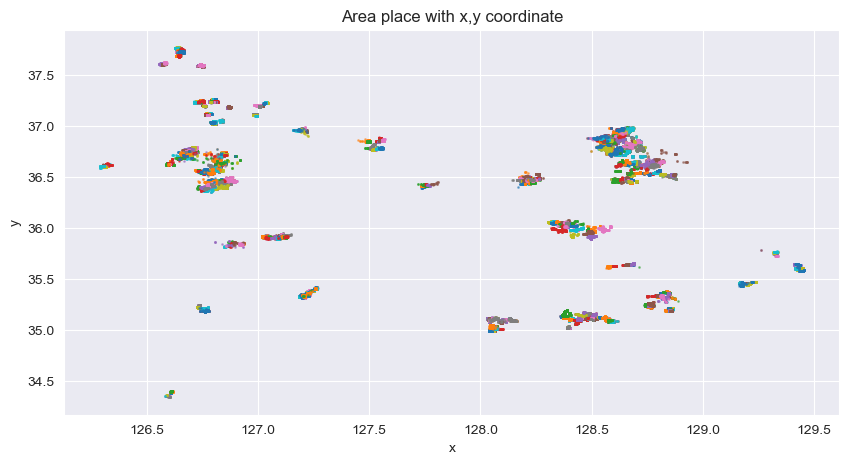

In [5]:
plt.figure(1, figsize=(10, 5))
for team_id in df['TeamId'].unique():
    plt.scatter(x = 'x' , y = 'y' , data = df[df['TeamId']==team_id],
                s = 1 , alpha = 0.5)
    plt.xlabel('x'), plt.ylabel('y')
plt.title('Area place with x,y coordinate')
plt.show()

### 3. 동/면/읍 별 sampling

### 4. 팀 1개가 작업한 범위, 작업 1개 당 팀의 갯수 구하기

In [6]:
# 팀 1개가 작업한 영역 범위 구하기 -> 10~20
area_per_team = df.groupby('TeamId')['area'].agg('sum')
q_low = area_per_team.quantile(0.05)
q_hi  = area_per_team.quantile(0.95)
area_filtered = area_per_team[(area_per_team < q_hi) & (area_per_team > q_low)]
print(area_filtered.describe())

count       834.000000
mean     218414.232974
std      128089.484130
min       29327.700000
25%      122067.750000
50%      190511.350000
75%      298528.025000
max      592657.500000
Name: area, dtype: float64


In [7]:
# 작업 1개 당 참여한 팀의 갯수; 평균 6개 팀
team_cnt_per_task = df.groupby('TaskId').agg({"TeamId":'nunique'})['TeamId']
print(team_cnt_per_task.describe())

count    142.000000
mean       6.535211
std        4.131975
min        2.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       21.000000
Name: TeamId, dtype: float64


# 2. Clustering use K-means

## 1. Training

1. Elbow point 결정
2. 군집화 training
    output : predicted 군집화 결과
3. 군집화 Evaluation
    output :
3. 점수 매길 때, 면적 균등 여부 및 지형지물 고려 여부에 맞게 판단

total area size : 1426709.1
predicted_label
0    120273.8
1    415784.7
2    243210.1
3    201350.8
4     84443.5
5     98760.8
6    262885.4
Name: area, dtype: float64
128.57828080000002 128.8886786 36.4459467 36.631640499999996


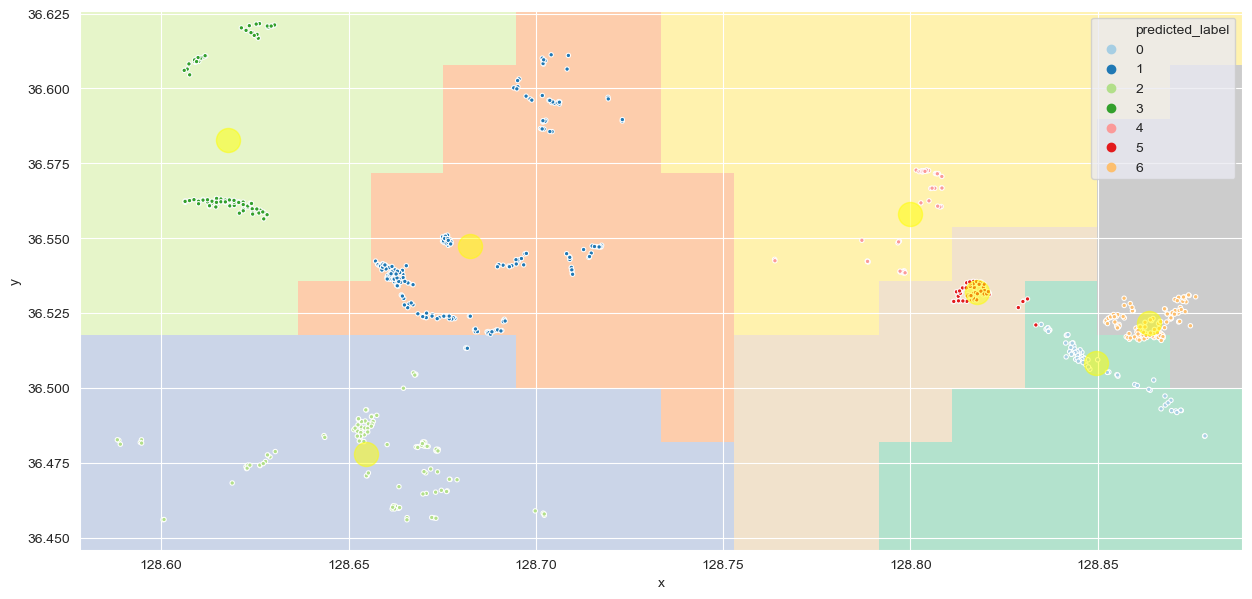

In [16]:
from sklearn.cluster import KMeans


df_taskid_filtered = df.copy()[df['TaskId']==618978]
total_area_size = df_taskid_filtered['area'].sum()
# x,y coordinate about area (779,2)
X1 = df_taskid_filtered[['x' , 'y']].iloc[: , :].values

MIN_AREA, MAX_AREA = 6600, 200000
# 최대 구역 갯수 : 하루 최대 방제 면적을 기준으로 분할, 결과 조각을 한 사람이 며칠에 걸쳐 방제
n = int(total_area_size/MAX_AREA)

# K-means algorithm
algorithm = (KMeans(n_clusters =  n,init='k-means++', n_init = 'auto' ,max_iter=1000,
                            tol=0.0001  , algorithm='elkan') )
algorithm.fit(df_taskid_filtered[['x','y']].values)
# input data에 의한 clustering 결과 (라벨, 중점)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_
# clustering 결과를 좌표에 포함
df_taskid_filtered['predicted_label'] = labels1.astype(int)
# 클러스터링 라벨 별 면적 df 생성ㅠ
df_area_size_per_label = df_taskid_filtered.groupby('predicted_label')['area'].agg('sum')
print("total area size : {}".format(total_area_size))
print(df_area_size_per_label)


h = 0.02
x_min, x_max = X1[:, 0].min()-0.01, X1[:, 0].max()+0.01
y_min, y_max = X1[:, 1].min()-0.01, X1[:, 1].max()+0.01
print(x_min,x_max,y_min,y_max)
# 좌표 상 x,y 축 격자 생성
xx, yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))

# 격자점에 대한 kmeans clustering
Z = algorithm.predict(np.c_[xx.ravel(),yy.ravel()])

plt.figure(1 , figsize = (15 , 7) )
plt.clf()

# 10*16 size로 결과 재배열
Z = Z.reshape(xx.shape)

# 격자점 클러스터링
plt.imshow(Z , interpolation='nearest',
           extent=(x_min, x_max, yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

# 데이터 클러스터링
sns.scatterplot(x="x", y="y", hue="predicted_label",
                data=df_taskid_filtered, palette='Paired', s=10);

# 중심점 뿌리기
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'yellow' , alpha = 0.5)

plt.ylabel('y') , plt.xlabel('x')

plt.show()

각 군집 별 동일 면적 클러스터링

2. 모든 Task에 대해 군집화 실행

# 평가척도

In [10]:
# from sklearn.cluster import KMeans
# # 1개 Task Id에 대하여, clustering
# '''Coordinate'''
# for task_id in df['TaskId'].unique():
#     team_cnt = team_cnt_per_task.loc[task_id]
#
#     task = df[df['TaskId']==task_id]
#     X1 = task[['x' , 'y']].iloc[: , :].values
#
#     algorithm = (KMeans(n_clusters = team_cnt ,init='k-means++', n_init = 'auto' ,max_iter=300,
#                             tol=0.0001,  random_state= 111  , algorithm='elkan') )
#
#     algorithm.fit(X1)
#
#     labels1 = algorithm.labels_
#
#     centroids1 = algorithm.cluster_centers_
#
#     h = 0.02
#     x_min, x_max = X1[:, 0].min()*0.999, X1[:, 0].max()*1.001
#     y_min, y_max = X1[:, 1].min()*0.999, X1[:, 1].max()*1.001
#
#     xx, yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))
#     Z = algorithm.predict(np.c_[xx.ravel(),yy.ravel()])
#
#     plt.figure(1 , figsize = (15 , 7) )
#     plt.clf()
#     Z = Z.reshape(xx.shape)
#     # 구분 배경
#     plt.imshow(Z , interpolation='nearest',
#                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#                cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')
#
#     plt.scatter( x = 'x' ,y = 'y' , data = task , c = labels1 ,s = 10, label=task )
#     # centroid 위치 표시
#     # plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'yellow' , alpha = 0.5)
#     plt.ylabel('y') , plt.xlabel('x')
#     plt.title('Task ID : {}, Team cnt : {}'.format(task_id, team_cnt))
#     plt.show()

In [11]:
# 예측 코드
# from sklearn.cluster import KMeans
#
#
# data = df.copy()[df['TaskId']==618978]
# total_area_size = df_taskid_filtered['area'].sum()
# # x,y coordinate about area (779,2)
# X1 = df_taskid_filtered[['x' , 'y']].iloc[: , :].values
# print("total area size : {}".format(total_area_size))
# MIN_AREA, MAX_AREA = 6600, 200000
#
# # 최대 구역 갯수 : 하루 최대 방제 면적을 기준으로 분할, 결과 조각을 한 사람이 며칠에 걸쳐 방제
# n = int(total_area_size/MAX_AREA)
#
# # K-means algorithm
# kmeans= (KMeans(n_clusters =  n,init='k-means++', n_init = 'auto' ,max_iter=1000,
#                             tol=0.0001  , algorithm='elkan') )
# clusters = kmeans.fit_predict(df_taskid_filtered[['x','y']])
#
# for i in range(256):
#     # Calculate area sizes for each cluster
#     df_taskid_filtered['predicted_label'] = labels1.astype(int)
#     # 클러스터링 라벨 별 면적 df 생성
#     df_area_size_per_label = df_taskid_filtered.groupby('predicted_label')['area'].agg('sum')
#     areas=df_area_size_per_label.tolist()
#
#     # Calculate the mean area size across all clusters
#     target_area = sum(areas) / len(areas)
#
#     # Calculate error for each cluster
#     errors = [abs(area - target_area) for area in areas]
#
#     # Find the cluster with the largest error
#     max_error_cluster = errors.index(max(errors))
#
#     # Move the furthest point from the centroid of that cluster to the closest centroid of another cluster
#     centroid_distances = kmeans.transform(data[['x', 'y']])
#     furthest_point_idx = np.argmax(centroid_distances[:, max_error_cluster])
#     furthest_point_coords = data.iloc[furthest_point_idx][['x', 'y']].values
#     closest_centroid_idx = np.argmin(centroid_distances[furthest_point_idx])
#     kmeans.cluster_centers_[max_error_cluster] = kmeans.cluster_centers_[closest_centroid_idx]
#     kmeans.cluster_centers_[closest_centroid_idx] = furthest_point_coords
#     clusters[furthest_point_idx] = closest_centroid_idx
#
#
#     print(df_area_size_per_label)


TypeError: 'ellipsis' object is not subscriptable